## t-SNE tutorial

[To understand the underlying justification behind the methodology better, read "Identifying topics in unlabeled documents: a methodological guide"](https://ngitopics.delabapps.eu/methodology.pdf)

The grouping or clustering of documents can be performed in various ways. Giving such a task to various humans would yield us multiple different groups of clusters. Similarly, various algorithms have different ideas regarding what constitutes an optimal model. They may disagree on fundamentals: for example, should the clusters be of a similar size? The same algorithm with other settings can return vastly different clusters. The single best algorithm performing well regardless of dataset and metric may not exist. Still, we can test multiple algorithms with various settings on a labeled dataset which we know is similar to the dataset with unknown topics we attempt to cluster. It is likely that the superior method on the labeled dataset will generalize well to the other datasets.

In B1 notebook, we presented a generative statistical model: LDA. It considers that each article is a mixture of topics, and each topic is a mixture of words. It has its advantages, but the main disadvantage is the difficulty of assigning just one topic to the article. It can be done in one of two ways presented in B1, maximum share (`maxshare`) or normalized maximum share (`maxtopic`) or using k-means. None of these methods performs well.

B2 notebook presents an alternative method: t-SNE. It is a dimensionality reduction technique, which takes a numerical representation of articles as an input (bag-of-words transformed to SVD matrix) and returns a two-dimensional map in which articles similar to each other are located nearby. Initialization with PCA or two-step optimization, first with high and later with low perplexity (perplexity annealing), allows to find global structure as well. A similar method, perplexity averaging, uses just one function with averaged perplexities. Yet another dimensionality reduction is UMAP, which you can install and is included in the *create_embeddings.py* file, but it requires *pynndescent>=0.5* which is incompatible with *openTSNE* library we use.

One other method we tested is vectorization, or word/document embeddings: doc2vec. In this method, all words or all articles are represented as an n-dimensional vector, which is derived from the hidden layer in a neural network predicting words from their environment (or the word's environment from the word).

Both in t-SNE and doc2vec, the output needs to be clustered. Clustering methods can be split into distance-based and density-based. Density, apart fromn distance, takes into account the vicinity of the path between two documents: is it dense or sparse. Clusters in dense regions are smaller, ceteris paribus, than in sparse regions. The two distance-based methods we use are k-means and Gaussian mixtures, which can be treated as generalized k-means. For density-based clustering, we chose HDBSCAN.

In order to ascertain what the optimal method is, we needed ground truth: the desired classification outcome. We have no valuable ground truth regarding topics in our datasets, as classification schemes vary between websites, if a website uses categories at all (the Guardian dataset does not; the only category we downloaded is technology). We rejected 20newsgroups and BBC News datasets for being too dissimilar to the data we examine. Reuters dataset properties resemble our datasets: it has multiple topics of unequal size, contains technical terms, and it is not too sensitive to cleaning methods or prone to volatile results.

If at least 80% of articles in a category belonged to another category, these categories were merged. After this procedure,  articles which belong to more than 1 category or to a category with less than 10 articles were discarded. In the final Reuters dataset, 9096 articles are split into 44 categories. In our experiment, we compared the 44 groups created by the tested methodologies to the 44 ground truth groups. We treated the testing as an unsupervised problem: the labels were hidden from the algorithm. The only information the algorithm was given was the number of desired clusters, equal to the number of ground truth categories.

There will be no perfect assignment for all goals. Goals may vary: if one has expert knowledge available and wants just to augment it, finding general – but possibly imperfect – clusters is beneficial. For no expert knowledge, small, coherent topics should be better. Generally in Reuters dataset, t-SNE achieves top results in all tested metrics, apart from weighted precision where it loses only slightly to SVD. Depending on the assignment method, sometimes Gaussian mixtures are preferred, and sometimes HDBSCAN achieves better results. As expected, with unevenly-sized clusters, HDBSCAN prevails over distance-based methods when Kuhn-Munkres algorithm is used to assign clusters to topics (instead of just largest topic in a cluster). The difference between distance-based clustering algorithms, k-means and Gaussian mixtures, is minor. In this notebook, we will present both distance-based algorithms and HDBSCAN, so that the proper method can be chosen for the particular problem, or all clustering methods can be tested on this or another dataset.

t-SNE settings achieve superior results with single perplexity in the range 50-75. We chose 50 for clarity and possiblity of distinguishing smaller topics.

As a demonstation, we will show both methods on the Guardian dataset, discussing their advantages and disadvantages.

# Requirements
### For this tutorial besides packages listed in requirements.txt you will need to install additional package implementing FFT-accelerated Interpolation-based t-SNE (FIt-SNE). Please follow installation guide described here: https://github.com/KlugerLab/FIt-SNE as specific steps depend on your OS.

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from datetime import datetime
import gc
import pickle
from openTSNE import TSNEEmbedding, affinity, initialization
from openTSNE.callbacks import ErrorLogger
import sys
from sklearn.cluster import AgglomerativeClustering, KMeans, OPTICS
from sklearn.mixture import GaussianMixture
from sklearn import metrics
import hdbscan
from collections import Counter
from itertools import chain
import json
import csv
from urllib.parse import urlparse

import sys

sys.path.append('./FIt-SNE/') # path to FFT-accelerated Interpolation-based t-SNE (FIt-SNE). You also need to download and compile FFTW, see: https://github.com/KlugerLab/FIt-SNE
from fast_tsne import fast_tsne

In [2]:
all_settings = [{'name': '150x50x4'}]  # the second to last perplexity is the chosen one for single perplexity settings
all_settings = [{**x, 'perps_averaging': [int(i) for i in x['name'].split('x')]} for x in all_settings]
all_settings = [{**x, 'perps': x['perps_averaging'][:2]} for x in all_settings]
iter_number = 1  # do not average, just one attempt
cl_sizes = [20]  # number of t-SNE clusters
ks_sizes = [20]  # number of LDA clusters, important for HDBSCAN. If there are more clusters than 20,
                 # reduce cut value manually not to exceed 20
mc_sizes = [25, 35, 50, 75, 100, 150, 200, 300]  # minimum cluster size for HDBSCAN
arg_dataset = 'guardian'
out_dir = './out/res_all/'

In [3]:
class Tsne:
    def __init__(self, name, embed_name):
        self.name = name
        self.embed_name = embed_name
        
        self.svd_norm_name = out_dir + '{}_X_svd_norm.pickle'.format(self.name)
        self.embedding_name = out_dir + 'field_embedding_{}.pickle'.format(self.embed_name)
        self.embedding_name_2 = out_dir + 'field_embedding2_{}.pickle'.format(self.embed_name)
        self.embedding_annealing_name = out_dir + 'field_embedding_annealing_{}.pickle'.format(self.embed_name)
        self.embedding_single_name = out_dir + 'field_single_{}.pickle'.format(self.embed_name)
        self.embedding_random_single_name = out_dir + 'field_random_single_{}.pickle'.format(self.embed_name)
        
    def create_embeddings(self, perps, perps_averaging):
        X_svd = pd.read_pickle(self.svd_norm_name)
        print('svd read', datetime.now())
        embedding_train_list = fast_tsne(X_svd, perplexity_list=perps_averaging, seed=42, file_suffix=self.name)
        pickle.dump(np.array(embedding_train_list), open(self.embedding_name, 'wb'))

        embedding_train_list_2 = fast_tsne(X_svd, perplexity_list=perps, seed=42, file_suffix=self.name)
        pickle.dump(np.array(embedding_train_list_2), open(self.embedding_name_2, 'wb'))

        affinities_train = affinity.PerplexityBasedNN(
            X_svd, perplexity=perps[0], metric='cosine', n_jobs=3, random_state=42)
        print('perplexity nn done', datetime.now())
        init_train = initialization.pca(X_svd, random_state=42)
        print('pca done', datetime.now())
        embedding_train = TSNEEmbedding(
            init_train,
            affinities_train,
            negative_gradient_method="fft",
            n_jobs=3,
            callbacks=ErrorLogger(),
            random_state=42
        )
        print('embedding done', datetime.now())
        embedding_train[:, 0] *= 10
        embedding_train[:, 1] *= 10
        print(embedding_train)
        print('0', np.min(embedding_train[:, 0]), np.max(embedding_train[:, 0]),
              np.min(embedding_train[:, 1]), np.max(embedding_train[:, 1]))
        embedding_train_1 = embedding_train.optimize(n_iter=250, exaggeration=12, momentum=0.5)
        print('1', np.min(embedding_train_1[:, 0]), np.max(embedding_train_1[:, 0]))
        embedding_train_2 = embedding_train_1.optimize(n_iter=750, exaggeration=1, momentum=0.8)
        print('2', np.min(embedding_train_2[:, 0]), np.max(embedding_train_2[:, 0]))
        affinities_train.set_perplexity(perps[1])
        embedding_train_3 = embedding_train_2.optimize(n_iter=500, momentum=0.8)
        print('3', np.min(embedding_train_3[:, 0]), np.max(embedding_train_3[:, 0]))
        print('embedding optimize done', datetime.now())
        pickle.dump(np.array(embedding_train_3), open(self.embedding_annealing_name, 'wb'))

    def create_single_embeddings(self, perps):
        X_svd = pd.read_pickle(self.svd_norm_name)
        embedding_train_single = fast_tsne(X_svd, perplexity=perps[-1], seed=42)
        pickle.dump(np.array(embedding_train_single), open(self.embedding_single_name, 'wb'))

        embedding_train_single_random = fast_tsne(
            X_svd, initialization='random', perplexity=perps[-1], seed=42)
        pickle.dump(np.array(embedding_train_single_random), open(self.embedding_random_single_name, 'wb'))

In [4]:
t = Tsne(name=arg_dataset, embed_name=arg_dataset + all_settings[0]['name'])
t.create_single_embeddings(perps=all_settings[0]['perps'])

In [5]:
def scores(dataframe, aggregates):
    # dummy function, if there is no ground truth to compare clustering to
    # see total_functions.py to see metrics
    return {'precision': 0}

`all_results` contains results, including predicted labels (*agg*) and metrics for these labels (defined in `scores` function above) for all possible settings, embeddings and clusterings. Distance-based clustering methods (Gaussian mixtures and k-means) use a constant seed for an iteration, so the results are reproducible. These methods allow us to define a precise number of clusters, in contrast to HDBSCAN, which defines the optimal number of clusters itself. Sometimes this number is larger than the desired number, defined in `ks_sizes`. In this case, we try multiple epsilons (defined in `epsilon_values`), which produce clusters differently (similarly to DBSCAN, they do not perform search for the optimal values locally). Consequently, we choose the epsilon value (in *cut*) which produces the number of clusters closest to the desired number.

In [6]:
all_results = []
df = None

for iter_count in range(iter_number):
    for particular_settings in all_settings:
        if particular_settings.get('cluster') is False:
            continue
        print(particular_settings)
        embed_name = particular_settings['name']
        full_embed_name = arg_dataset + embed_name

        for embedding_type in ['single']:
            if embedding_type == 'averaging':
                embeddings = pd.read_pickle(
                    out_dir + 'field_embedding_{}{}.pickle'.format(arg_dataset, embed_name))
            elif embedding_type == 'averaging2':
                embeddings = pd.read_pickle(
                    out_dir + 'field_embedding2_{}{}.pickle'.format(arg_dataset, embed_name))
            elif embedding_type == 'annealing':
                embeddings = pd.read_pickle(
                    out_dir + 'field_embedding_annealing_{}{}.pickle'.format(arg_dataset, embed_name))
            elif embedding_type == 'single':
                embeddings = pd.read_pickle(
                    out_dir + 'field_single_{}{}.pickle'.format(arg_dataset, embed_name))
            elif embedding_type == 'umap':
                embeddings = pd.read_pickle(
                    out_dir + 'field_umap_{}{}.pickle'.format(arg_dataset, embed_name))

            print(embeddings.shape)

            for nc in cl_sizes:
                print('tsne', nc)
                gm = GaussianMixture(n_components=nc, random_state=iter_count)
                agg = gm.fit_predict(embeddings)

                all_results.append({**{
                    'dataset': arg_dataset,
                    'iter': iter_count,
                    'model': 'tsne',
                    'cluster': 'gaussian_mixture',
                    'embed_name': embed_name,
                    'embed_type': embedding_type,
                    'nc': nc,
                    'agg': agg,
                }, **scores(df, agg)})

                print(nc)
                print(len(all_results))
                print(all_results[-1]['precision'], datetime.now())

                print('tsne', nc)
                km = KMeans(n_clusters=nc, random_state=iter_count)
                agg = km.fit_predict(embeddings)

                all_results.append({**{
                    'dataset': arg_dataset,
                    'iter': iter_count,
                    'model': 'tsne',
                    'cluster': 'kmeans',
                    'embed_name': embed_name,
                    'embed_type': embedding_type,
                    'nc': nc,
                    'agg': agg,
                }, **scores(df, agg)})

                print(nc)
                print(len(all_results))
                print('iter', iter_count, all_results[-1]['precision'], datetime.now())

            epsilons = np.hstack([np.arange(0.5, 1.3, 0.02), np.arange(
                            1.4, 8, 0.4)])

            for mcs in mc_sizes:
                hdb = hdbscan.HDBSCAN(min_cluster_size=mcs, gen_min_span_tree=True)
                hdb.fit(embeddings)

                hdb_labels_all = {'default': hdb.labels_}
                # epsilon_value = 10
                if len(set(hdb_labels_all['default'])) > ks_sizes[0]:
                    hdb_labels_all = []
                    epsilons_iter = epsilons * (1 + 0.2*(iter_count - (iter_number // 2)) / iter_number)
                    for epsilon_value in epsilons_iter:
                        cls = hdb.single_linkage_tree_.get_clusters(epsilon_value)
                        if len(set(cls)) <= ks_sizes[0] * 2:
                            hdb_labels_all.append([cls, epsilon_value, abs(len(set(cls))-ks_sizes[0])])
                    hdb_labels_all.sort(key=lambda x: x[-1])
                    hdb_labels_all = {epsilon: cls for cls, epsilon, key in hdb_labels_all[:1]}

                for cut, hdb_labels in hdb_labels_all.items():
                    all_results.append({**{
                        'dataset': arg_dataset,
                        'iter': iter_count,
                        'embed_name': embed_name,
                        'embed_type': embedding_type,
                        'model': 'tsne',
                        'cluster': 'hdbscan',
                        'cut': cut,
                        'mcs': mcs,
                        'agg': hdb_labels,
                    }, **scores(df, hdb_labels)})

                print(mcs)
                print(len(all_results))
                print(all_results[-1]['precision'], datetime.now())

{'name': '150x50x4', 'perps_averaging': [150, 50, 4], 'perps': [150, 50]}
(7933, 2)
tsne 20
20
1
0 2021-12-22 18:34:00.175652
tsne 20
20
2
iter 0 0 2021-12-22 18:34:00.834690
25
3
0 2021-12-22 18:34:01.211537
35
4
0 2021-12-22 18:34:01.578355
50
5
0 2021-12-22 18:34:01.919083
75
6
0 2021-12-22 18:34:02.082037
100
7
0 2021-12-22 18:34:02.272333
150
8
0 2021-12-22 18:34:02.503828
200
9
0 2021-12-22 18:34:02.774931
300
10
0 2021-12-22 18:34:03.129210


In [7]:
ar = pd.DataFrame(all_results)
ar

dataset  iter model           cluster embed_name embed_type    nc  \
0  guardian     0  tsne  gaussian_mixture   150x50x4     single  20.0   
1  guardian     0  tsne            kmeans   150x50x4     single  20.0   
2  guardian     0  tsne           hdbscan   150x50x4     single   NaN   
3  guardian     0  tsne           hdbscan   150x50x4     single   NaN   
4  guardian     0  tsne           hdbscan   150x50x4     single   NaN   
5  guardian     0  tsne           hdbscan   150x50x4     single   NaN   
6  guardian     0  tsne           hdbscan   150x50x4     single   NaN   
7  guardian     0  tsne           hdbscan   150x50x4     single   NaN   
8  guardian     0  tsne           hdbscan   150x50x4     single   NaN   
9  guardian     0  tsne           hdbscan   150x50x4     single   NaN   

                                                 agg  precision      cut  \
0  [9, 12, 9, 7, 9, 11, 12, 15, 18, 7, 4, 7, 6, 3...          0      NaN   
1  [4, 16, 4, 9, 3, 9, 16, 17, 11, 12, 5, 12, 1, ...          0      NaN   
2  [-1, -1, -1, 4, -1, -1, -1, -1, -1, -1, -1, -1...          0     1.04   
3  [15, -1, 15, 7, -1, 5, -1, 9, -1, 15, 15, 15, ...          0      3.8   
4  [6, -1, 6, 1, -1, 5, -1, 21, -1, 6, 11, -1, 14...          0      4.2   
5  [9, -1, 9, -1, -1, 2, -1, 5, -1, 9, 9, 9, 4, 9...          0  default   
6  [5, 5, 5, -1, 5, 1, 5, 4, -1, 5, 5, 5, -1, -1,...          0  default   
7  [2, 2, 2, -1, 2, 0, 2, 3, -1, 2, 2, 2, -1, -1,...          0  default   
8  [1, 1, 1, -1, -1, 0, 1, -1, -1, 1, 1, 1, -1, -...          0  default   
9  [0, 0, 0, -1, 0, 1, 0, -1, 0, 0, -1, 0, -1, 0,...          0  default   

     mcs  
0    NaN  
1    NaN  
2   25.0  
3   35.0  
4   50.0  
5   75.0  
6  100.0  
7  150.0  
8  200.0  
9  300.0

In [8]:
from collections import Counter
ar['agg_counts'] = ar['agg'].apply(Counter).apply(lambda x: x.most_common(20))
ar['agg_unique'] = ar['agg_counts'].apply(len)

In [9]:
ar.iloc[0]['agg'].shape

(7933,)

In [10]:
ar

dataset  iter model           cluster embed_name embed_type    nc  \
0  guardian     0  tsne  gaussian_mixture   150x50x4     single  20.0   
1  guardian     0  tsne            kmeans   150x50x4     single  20.0   
2  guardian     0  tsne           hdbscan   150x50x4     single   NaN   
3  guardian     0  tsne           hdbscan   150x50x4     single   NaN   
4  guardian     0  tsne           hdbscan   150x50x4     single   NaN   
5  guardian     0  tsne           hdbscan   150x50x4     single   NaN   
6  guardian     0  tsne           hdbscan   150x50x4     single   NaN   
7  guardian     0  tsne           hdbscan   150x50x4     single   NaN   
8  guardian     0  tsne           hdbscan   150x50x4     single   NaN   
9  guardian     0  tsne           hdbscan   150x50x4     single   NaN   

                                                 agg  precision      cut  \
0  [9, 12, 9, 7, 9, 11, 12, 15, 18, 7, 4, 7, 6, 3...          0      NaN   
1  [4, 16, 4, 9, 3, 9, 16, 17, 11, 12, 5, 12, 1, ...          0      NaN   
2  [-1, -1, -1, 4, -1, -1, -1, -1, -1, -1, -1, -1...          0     1.04   
3  [15, -1, 15, 7, -1, 5, -1, 9, -1, 15, 15, 15, ...          0      3.8   
4  [6, -1, 6, 1, -1, 5, -1, 21, -1, 6, 11, -1, 14...          0      4.2   
5  [9, -1, 9, -1, -1, 2, -1, 5, -1, 9, 9, 9, 4, 9...          0  default   
6  [5, 5, 5, -1, 5, 1, 5, 4, -1, 5, 5, 5, -1, -1,...          0  default   
7  [2, 2, 2, -1, 2, 0, 2, 3, -1, 2, 2, 2, -1, -1,...          0  default   
8  [1, 1, 1, -1, -1, 0, 1, -1, -1, 1, 1, 1, -1, -...          0  default   
9  [0, 0, 0, -1, 0, 1, 0, -1, 0, 0, -1, 0, -1, 0,...          0  default   

     mcs                                         agg_counts  agg_unique  
0    NaN  [(9, 1130), (12, 662), (18, 555), (13, 546), (...          20  
1    NaN  [(4, 578), (14, 516), (10, 501), (5, 494), (2,...          20  
2   25.0  [(-1, 7587), (3, 30), (2, 27), (7, 27), (12, 2...          20  
3   35.0  [(15, 4377), (-1, 1152), (5, 334), (12, 274), ...          20  
4   50.0  [(6, 3562), (-1, 1654), (5, 318), (7, 288), (3...          20  
5   75.0  [(9, 5326), (-1, 1222), (1, 265), (5, 253), (0...          11  
6  100.0  [(5, 5495), (-1, 1290), (1, 320), (0, 257), (4...           7  
7  150.0  [(2, 5240), (-1, 1664), (0, 664), (3, 207), (1...           5  
8  200.0                  [(1, 5094), (-1, 2276), (0, 563)]           3  
9  300.0                  [(0, 5398), (-1, 2119), (1, 416)]           3

In [11]:
from main_settings import res, mods

This seems to be an example of HDBSCAN not working optimally. For minimum cluster sizes of 25 and 35, almost all articles are assigned to "noise" category (-1). `mcs >= 75` creates a very small number of clusters by default. Consequently, for demonstrations we will use `mcs = 50`. Although many articles are assigned either to noise or one very large cluster, the number of articles in further clusters gives us hope that these clusters will be consistent.

Let us use the Website class, only modifying it slightly to pass computed labels in the `create_jsons` function instead of computing them, and augmenting the dataframes with titles and stemmed tokenized texts, to create keywords for clusters automatically.

In [12]:
from ast import literal_eval
import os
website_dir_out = os.path.join('website', 'out') + os.sep
website_dir_map = os.path.join('website', 'umb') + os.sep

os.makedirs(website_dir_out, exist_ok=True)
os.makedirs(website_dir_map, exist_ok=True)

body_token_column = 'body_token_stemmed'
def flatten(x):
    return [a for b in x for a in b]

class Website:
    def __init__(self, name, embed_name,
        part_name, link_column, links_dict_filename=None,
        maintain_domains=None, maintain_sites=None):
        self.name = name
        self.embed_name = embed_name
        
        self.embedding_single_name = out_dir + 'field_single_{}.pickle'.format(self.embed_name)
        self.alls_name = out_dir + '{}_df.pickle'.format(self.name)
        self.title_name = '{}_articles.csv'.format(self.name)

        self.part_name = part_name
        self.link_column = link_column
        self.links_dict_filename = links_dict_filename
        self.maintain_domains = maintain_domains
        self.maintain_sites = maintain_sites

        self.n_components = 15
        self.max_articles = 15000

    def create_jsons(self, particular_settings, cluster, aggm):
        perps_single = particular_settings['perps'][-1]
        embeddings = pd.read_pickle(self.embedding_single_name)
        arts = pd.read_pickle(self.alls_name)
        
        titles = pd.read_csv(self.title_name)
        arts['title'] = arts['url'].map(titles[['webUrl', 'webTitle']].set_index('webUrl').to_dict()['webTitle'])
        
        dfs = []
        for i in sorted(os.listdir(mods)):
            dfs.append(pd.read_csv(os.path.join(mods, i), index_col=0))
        mod_df = pd.concat(dfs)
        arts[body_token_column] = arts['url'].map(mod_df[['url', body_token_column]].set_index('url').to_dict()[body_token_column]).apply(literal_eval)

        arts['topic'] = aggm.astype(str)
        arts['name'] = aggm.astype(str)
        arts['link'] = arts['url']
        arts['x'] = embeddings[:,0]
        arts['y'] = embeddings[:,1]

        if self.part_name != '':
            links_dict = pd.read_pickle(self.links_dict_filename)
            arts[self.link_column] = arts[self.link_column].map(links_dict).fillna(arts[self.link_column])
            arts['domain'] = arts[self.link_column].apply(lambda x: urlparse(x).netloc)
            arts['domain_country'] = arts['domain'].str.split('.').apply(lambda x: x[-1])
            print(arts['domain_country'].value_counts())
            print(arts.loc[arts['domain_country'].isin(self.maintain_domains), 'domain'].value_counts())
            arts = arts.loc[arts['domain_country'].isin(self.maintain_domains) | arts['domain'].isin(self.maintain_sites)]


        if arts.shape[0] > self.max_articles:
            arts = arts.sample(n=self.max_articles, random_state=1)

        kw = {str(i): [] for i in range(self.n_components)}
        topics_counters = {}
        new_data = []
        arts['title_all'] = arts['title']
        for topic_name, topic in arts.groupby('name'):
            if topic_name == '-1':
                continue
            topic['link'] = topic['link']
            links = topic['link'].tolist()
            headlines = topic['title_all'].tolist()
            
            topics_counters['{}'.format(int(topic_name))] = Counter(chain(*topic[body_token_column].apply(flatten).tolist()))
            
            for i in range(len(headlines)):
                if (type(headlines[i]) != str) and np.isnan(headlines[i]):
                    headlines[i] = topic['text'].iloc[i][:100] + '...'
                headlines[i] = ' / ' + headlines[i]
            new_data.extend(list(zip(topic['x'].values, topic['y'].values,
                                     headlines,
                                     [topic_name]*(topic['x'].shape[0]), links)))


        keywords_topics = {}

        sum_topics_counters = sum([v for k, v in topics_counters.items()], Counter())

        for topic_tsne_name, topic_tsne_counter in topics_counters.items():
            topic_main_name = '_'.join(topic_tsne_name.split('_')[:-1])
            counter_df = pd.concat([pd.Series(topic_tsne_counter), pd.Series(sum_topics_counters)], axis=1)
            counter_df.columns = ['tsne_topic', 'keyword']
            counter_df = counter_df.loc[~counter_df['tsne_topic'].isna()]
            counter_df['ratio'] = counter_df['tsne_topic'] / counter_df['keyword']
            counter_df['log_ratio'] = counter_df['tsne_topic'] / np.log(counter_df['keyword'])
            counter_df['sqrt_ratio'] = counter_df['tsne_topic'] / (counter_df['keyword']**(1/2))

            print(topic_tsne_name, counter_df.sort_values('sqrt_ratio', ascending=False).iloc[:5].index, counter_df.sort_values('log_ratio', ascending=False).iloc[:5].index, counter_df.sort_values('ratio', ascending=False).iloc[:5].index)

            keywords_topics[topic_tsne_name] = counter_df.sort_values('sqrt_ratio', ascending=False).iloc[:5].index.tolist()

        topic_dict = [{'topic': topic.split('_')[-1], 'name': keywords_topics[topic][0], 'keywords': keywords_topics[topic],
              } for topic in topics_counters.keys()]

        print(topic_dict)
        json.dump({"main": topic_dict, "annotations": []}, open(website_dir_out + 'umb{}_{}{}{}_d3_settings.json'.format(cluster, self.name, self.part_name, perps_single), 'w'))

        dfnew = pd.DataFrame(new_data, columns=['x', 'y', 'headline', 'topic', 'link'])
        dfnew.index.name = 'index'
        # dfnew = dfnew.sample(5000)
        topic_counts = dfnew['topic'].value_counts()
        # print(name, topic_counts)
        dfnew.to_csv(website_dir_out + 'umb{}_{}{}{}_d3.csv'.format(cluster, self.name, self.part_name, perps_single), quoting=csv.QUOTE_NONNUMERIC)

    def create_html(self, particular_settings, cluster):
        perps_single = particular_settings['perps'][-1]
        html = '''<!DOCTYPE html>
<meta charset="utf-8">
<link rel="stylesheet" type="text/css" href="./css/scatter.css">

<link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/bootstrap@5.0.1/dist/css/bootstrap.min.css" integrity="undefined" crossorigin="anonymous">
<script src="https://cdn.jsdelivr.net/npm/bootstrap@5.0.1/dist/js/bootstrap.min.js" integrity="undefined" crossorigin="anonymous"></script>

<!-- Load d3.js -->
<script src="https://d3js.org/d3.v4.js"></script>
<script src="https://rawgit.com/susielu/d3-annotation/master/d3-annotation.min.js"></script>


<!-- Load color scale -->
<script src="https://d3js.org/d3-scale-chromatic.v1.min.js"></script>

<script src="scatter_common.js"></script>

<!-- Create a div where the graph will take place -->

<div class="container">
        <div class="row">
                <div class="col-md-10">
                        <div id="my_title"></div><br>
                        <div id="my_dataviz"></div>
                </div>
                <div class="col-md-2">
                        <div id="my_kw"></div>
                </div>
        </div>
</div>
<script>
load_map('umb{}_{}{}{}');
</script>
'''.format(cluster, self.name, self.part_name, perps_single)
        with open(website_dir_map + 'umb{}_{}{}{}.html'.format(cluster, self.name, self.part_name, perps_single), 'w') as f:
            f.write(html)

In [13]:
ar

dataset  iter model           cluster embed_name embed_type    nc  \
0  guardian     0  tsne  gaussian_mixture   150x50x4     single  20.0   
1  guardian     0  tsne            kmeans   150x50x4     single  20.0   
2  guardian     0  tsne           hdbscan   150x50x4     single   NaN   
3  guardian     0  tsne           hdbscan   150x50x4     single   NaN   
4  guardian     0  tsne           hdbscan   150x50x4     single   NaN   
5  guardian     0  tsne           hdbscan   150x50x4     single   NaN   
6  guardian     0  tsne           hdbscan   150x50x4     single   NaN   
7  guardian     0  tsne           hdbscan   150x50x4     single   NaN   
8  guardian     0  tsne           hdbscan   150x50x4     single   NaN   
9  guardian     0  tsne           hdbscan   150x50x4     single   NaN   

                                                 agg  precision      cut  \
0  [9, 12, 9, 7, 9, 11, 12, 15, 18, 7, 4, 7, 6, 3...          0      NaN   
1  [4, 16, 4, 9, 3, 9, 16, 17, 11, 12, 5, 12, 1, ...          0      NaN   
2  [-1, -1, -1, 4, -1, -1, -1, -1, -1, -1, -1, -1...          0     1.04   
3  [15, -1, 15, 7, -1, 5, -1, 9, -1, 15, 15, 15, ...          0      3.8   
4  [6, -1, 6, 1, -1, 5, -1, 21, -1, 6, 11, -1, 14...          0      4.2   
5  [9, -1, 9, -1, -1, 2, -1, 5, -1, 9, 9, 9, 4, 9...          0  default   
6  [5, 5, 5, -1, 5, 1, 5, 4, -1, 5, 5, 5, -1, -1,...          0  default   
7  [2, 2, 2, -1, 2, 0, 2, 3, -1, 2, 2, 2, -1, -1,...          0  default   
8  [1, 1, 1, -1, -1, 0, 1, -1, -1, 1, 1, 1, -1, -...          0  default   
9  [0, 0, 0, -1, 0, 1, 0, -1, 0, 0, -1, 0, -1, 0,...          0  default   

     mcs                                         agg_counts  agg_unique  
0    NaN  [(9, 1130), (12, 662), (18, 555), (13, 546), (...          20  
1    NaN  [(4, 578), (14, 516), (10, 501), (5, 494), (2,...          20  
2   25.0  [(-1, 7587), (3, 30), (2, 27), (7, 27), (12, 2...          20  
3   35.0  [(15, 4377), (-1, 1152), (5, 334), (12, 274), ...          20  
4   50.0  [(6, 3562), (-1, 1654), (5, 318), (7, 288), (3...          20  
5   75.0  [(9, 5326), (-1, 1222), (1, 265), (5, 253), (0...          11  
6  100.0  [(5, 5495), (-1, 1290), (1, 320), (0, 257), (4...           7  
7  150.0  [(2, 5240), (-1, 1664), (0, 664), (3, 207), (1...           5  
8  200.0                  [(1, 5094), (-1, 2276), (0, 563)]           3  
9  300.0                  [(0, 5398), (-1, 2119), (1, 416)]           3

In [14]:
web = Website(name=arg_dataset, embed_name=arg_dataset + all_settings[0]['name'],
             part_name='', link_column='link')
web.create_jsons(particular_settings=all_settings[0], cluster='hdbscan', aggm=ar.loc[(ar['cluster'] == 'hdbscan') & (ar['mcs'] == 50), 'agg'].values[0])
web.create_html(particular_settings=all_settings[0], cluster='hdbscan')

web.create_jsons(particular_settings=all_settings[0], cluster='gm', aggm=ar.loc[(ar['cluster'] == 'gaussian_mixture'), 'agg'].values[0])
web.create_html(particular_settings=all_settings[0], cluster='gm')

/home/delab/miniconda3/envs/tutorials/lib/python3.7/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0 Index(['fbi', 'appl', 'san_bernardino', 'encrypt', 'the'], dtype='object') Index(['193', 'lethem', 'passwordcrack', 'currentlylock', 'kasperkev'], dtype='object') Index(['193', 'companyheld', 'fbifriend', 'teleco', 'conyer'], dtype='object')
1 Index(['eco_rate', 'second_combin', 'car_review', 'acceler_062mph',
       'fuel_consumpt'],
      dtype='object') Index(['56gkm', '47.9mpg', 'catalept', 'kookier', '£27230'], dtype='object') Index(['56gkm', '20d', '62_mile', 'aventura', 'womanchild'], dtype='object')
10 Index(['tax', 'corpor_tax', 'ireland', 'hmrc', 'luxembourg'], dtype='object') Index(['€48.4bn', 'eamonn', '1114am', 'trulylfc', '1214pm'], dtype='object') Index(['€48.4bn', 'taxcompetit', 'designerlabel', 'goitalon', 'kleinbard'], dtype='object')
11 Index(['twitter', 'tweet', 'dorsey', 'the', '.'], dtype='object') Index(['daraprim', 'mtn', 'httpst.cod39qdlgmdv', 'pf',
       'pic.twitter.comskvtp4o9ew'],
      dtype='object') Index(['plethor', 'streisand', '548m', '16.14', '762

/home/delab/miniconda3/envs/tutorials/lib/python3.7/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0 Index(['huawei', '5g', 'the', 'meng', '5g_network'], dtype='object') Index(['sevenyearban', 'noncoerc', 'sureti', 'lijan', 'branstad'], dtype='object') Index(['ontix', 'xilinx', 'crosstechnolog', 'farben', 'ultralowlat'], dtype='object')
1 Index(['amazon', 'the', '.', 'to', 'bezo'], dtype='object') Index(['£1.55bn', '£450000', 'gizzi', 'meraki', 'grennan'], dtype='object') Index(['£1.55bn', '45000squaremetr', 'moretherefath', 'notther', 'aalto'], dtype='object')
10 Index(['the', 'youtub', '.', 'to', 'of'], dtype='object') Index(['22.4bn', 'jae', 'dftba', 'vlogbroth', 'fairyfloss'], dtype='object') Index(['allahu', 'vindict', 'bottomlin', 'crampsshak', 'unbidden'], dtype='object')
11 Index(['car', 'the', '.', 'vehicl', 'a'], dtype='object') Index(['trackon', 'iwasaki', '585acr', 'effervesc', 'jonsonbilduppdraget'], dtype='object') Index(['£22750', 'ceausescuera', '5.3km', 'estima', '£7750'], dtype='object')
12 Index(['.', 'the', 'to', 'a', 'and'], dtype='object') Index(['simplebutslic

To run the website, you need to execute a temporary server. In Python, it requires running `python3 -m http.server <port_number>`, e.g. `python3 -m http.server 8080` in the website directory, then you will be able to access http://0.0.0.0:8080/umb/umbgm_guardian50.html and http://0.0.0.0:8080/umb/umbhdbscan_guardian50.html: interactive versions of graphs.

In this case, Gaussian mixtures properly split the area about cars into clusters on Uber and on cars in general, while HDBSCAN joins them together. On the other hand, the general cluster of articles in the middle is artificially split by Gaussian mixtures into mostly irrelevant clusters, as one can see from the automatically assigned keywords: there are no actually specific topics for these clusters. On the other hand, almost all HDBSCAN clusters (apart from the large one) consist of articles which are clearly very similar to each other.

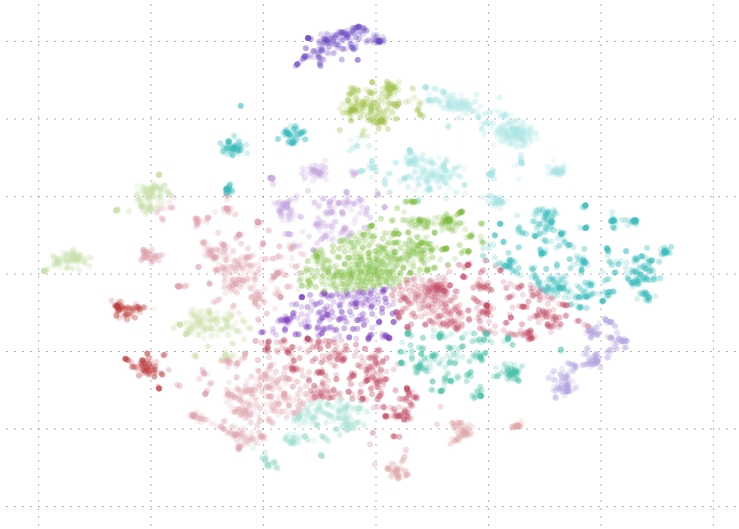

*Gaussian mixtures*

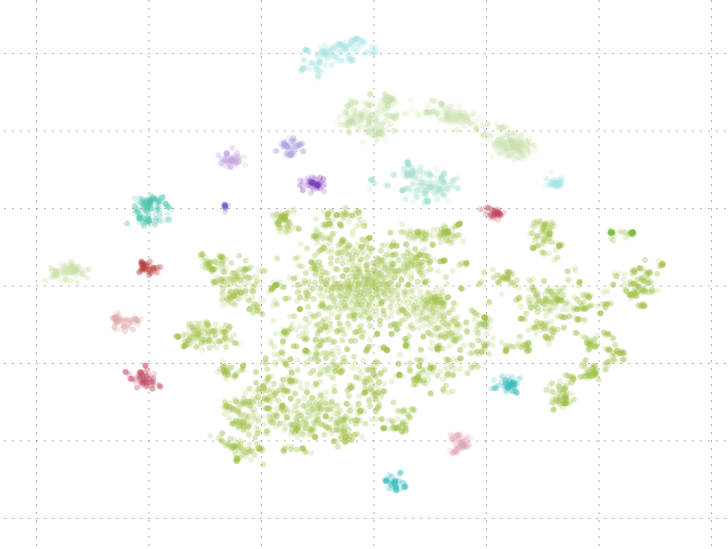

*HDBSCAN*